## Background

The data were collected in an effort to monitor and evaluate the Primary School Deworming Project (PSDP), which was a primary school health intervention study in rural Kenya. From 1998 until 2002, medical treatment for intestinal helminths was provided to 75 rural Kenyan primary schools in the western district of Busia. Treatment was randomly “phased in” to the 75 schools between 1998 and 2001 as described below.  
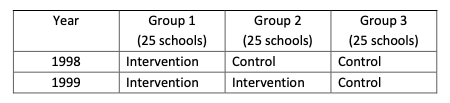

The PSDP intervention included both drug treatment and health education. Children who participated in the program received albendazole to treat the geohelminths and praziquantel to treat schistosomiasis. The educational component of the intervention focused on teaching children about avoiding the disease. Health educators explained the transmission vectors for different types of helminths and also promoted hand-washing, wearing shoes, and avoiding contact with fresh water.   

The data in this project includes only data a random smaller sample of children from each school. The main outcome of interest is attendance, which is defined as presence during a visit.   
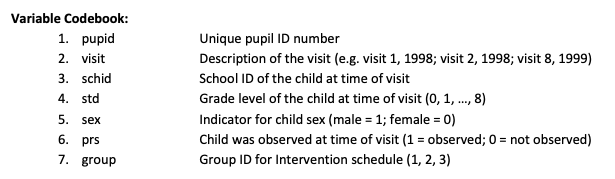  


## Main Findings

1. There wa positive effect of intervention on improving attendance in 1998 and 1999.
2. The effect varied due to length of intervention and sex. Longer length of intervention leads to better effect of intervention on improving attendance in 1998, while longer length of intervention alleviates the positive effect of intervention on improving attendance in 1999. Better effect of intervention on improving was found in female compared to male in both 1998 and 1999.

## Data Preparation

### Wrangling Data

In [37]:
#Gain a hint about the data
head(worm)

,pupid,visit,schid,std,sex,prs,group
33,1080002,"Visit 1, 1998",108,0,0,1,3
34,1080002,"Visit 2, 1998",108,0,0,1,3
38,1080002,"Visit 6, 1998",108,0,0,0,3
40,1080002,"Visit 8, 1998",108,0,0,1,3
43,1080002,"Visit 3, 1999",108,0,0,1,3
48,1080002,"Visit 8, 1999",108,0,0,0,3


In [42]:
#Reshape the dataset
final<-worm %>%
  separate(visit, c("visit_num", "visit_year"), ", ")%>%
  separate(visit_num, c("visit", "num"), " ")
final$time<-as.numeric(ifelse(final$visit_year==1999,as.numeric(final$num)+8,final$num))
final$trt<-ifelse(final$group==1,1,ifelse(final$group==3,0,ifelse(final$visit_year==1999,1,0)))
# rearrange the dataset by group, studentid, and viit time
final_order<-final[order(final$group,final$pupid,final$time),-2]
head(final_order)

,pupid,num,visit_year,schid,std,sex,prs,group,time,trt
5573,1083031,5,1998,206,5,1,NA,1,5,1
11320,1090643,8,1998,210,0,NA,NA,1,8,1
11322,1090643,2,1999,210,0,NA,NA,1,10,1
12273,1091704,1,1998,219,1,NA,NA,1,1,1
14721,1093030,1,1998,117,4,1,1,1,1,1
14722,1093030,2,1998,117,4,1,0,1,2,1


### Missing Pattern

In [44]:
#Calculate the number of missing visit 
missing_visit<-final_order%>% group_by(pupid) %>% 
  summarise(visitnum=sum(!is.na(time)),missingfreq=round((16-sum(!is.na(time)))/16,2))
final2<-merge(missing_visit,final_order[!duplicated(final_order$pupid),])
# calculate the the missing rate per sex group and per year
final2 %>% group_by(sex,visit_year) %>% summarise(meanfreq=round(mean(missingfreq,na.rm = TRUE),2))
# No sex differnece is found in missing rate of visit. 
# There were more missing visit in 1999 compared to which in 1998.
#calculate the the missing rate per school
a<-final2 %>% group_by(schid,) %>% summarise(meanfreq=mean(missingfreq,na.rm = TRUE))
# students in school 133 and school 134 are more likely to have missing visit compared to students in other school
# calculate the the missing rate per group
final2 %>% group_by(group) %>% summarise(meanfreq=round(mean(missingfreq,na.rm = TRUE),2))
#No group difference is founded in missing rate of visit.
final_clean<-na.omit(final_order)#3232 subjects (466 subjects were excluded due to missing value)

sex,visit_year,meanfreq
0,1998,0.48
0,1999,0.51
1,1998,0.48
1,1999,0.51
NA,1998,0.60
NA,1999,0.67


group,meanfreq
1,0.50
2,0.50
3,0.49


### Quality Check

In [54]:
# Check whether there were students tranfering to different schools
check1<-final_clean%>%group_by(pupid)%>%summarise(num_school=length(levels(as.factor(schid))))
#198 children didn't stayed at a same school during the time 

# check whether students' std(grade level) increased with time
check2<-final_clean %>% group_by(pupid,visit_year)%>%summarise(min=min(std,na.rm = T))
check2_1<-spread(check2,visit_year,min)
check2_2<-check2_1[check2_1$`1999`-check2_1$`1998`<0 & !is.na(check2_1$`1999`-check2_1$`1998`),]
# 17 students held back

In [55]:
# Removed children with transfering school records
final_clean1<-final_clean[final_clean$pupid %in% check_keep$pupid & ! final_clean$pupid %in% check2_2$pupid,]
#3025 subjects (207 subjects were excluded due to transfering school records or helding back)


   0    1 
   2 1458 

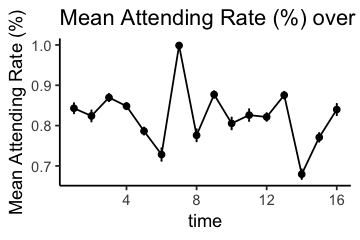

In [56]:
# Plot the mean attendance rate per visit
options(repr.plot.width=3, repr.plot.height=2)
final_clean1%>%
  group_by(time) %>%
  summarise(Mean = mean(prs,na.rm = TRUE),sd=sqrt(mean(prs,na.rm = TRUE)*(1-mean(prs,na.rm = TRUE))/length(prs))) %>%
  ggplot(aes(x=time, y=Mean)) +
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.1, position=position_dodge(0.15)) +
  geom_line()+
  geom_point()+
  scale_color_brewer(palette="Paired")+
  labs(title="Mean Attending Rate (%) over Time", y="Mean Attending Rate (%)")+ theme_classic()

In [81]:
table(final_clean1[final_clean1$time==7,"prs"]) 
#Decide to remove measurement in time=7, as there is few varaiblity among the outcome variable.
final_clean2<-final_clean1[!final_clean1$time==7,]
#3020 subjects (5 subjects were excluded as they only had data at time=7)


   0    1 
   2 1458 

In [82]:
##check whether there are schools with 100% absence rate for all the time
check3<-final_clean2%>%
  group_by(time,schid) %>%
  summarise(Mean = mean(prs,na.rm = TRUE),sd=sqrt(mean(prs,na.rm = TRUE)*(1-mean(prs,na.rm = TRUE))/length(prs)))
check3_1<-check3%>%group_by(schid)%>%summarise(count_all1=sum(Mean==1),count_all0=sum(Mean==0),count=sum(!is.na(schid)))
check3_1[check3_1$count_all0==1,]
#one center-134 had all student sampled not attending school once.

schid,count_all1,count_all0,count
134,1,1,7


## Descriptive Statistics

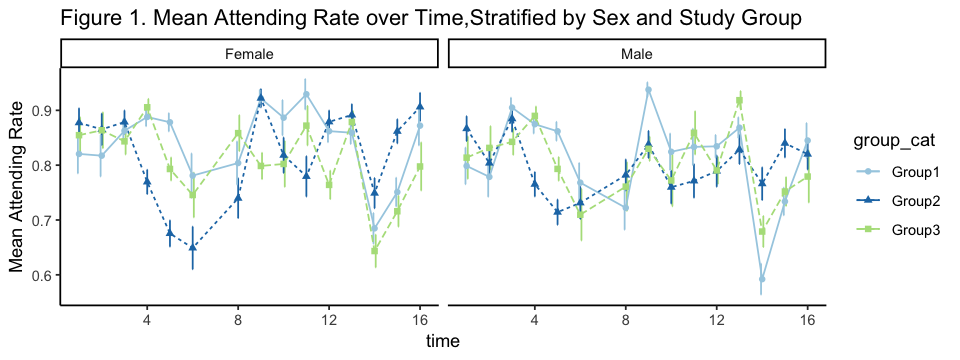

In [122]:
##stratified by # of absense per person in each time point
final_clean2$gender<-factor(final_clean2$sex,labels = c("Female","Male"))
final_clean2$group_cat<-factor(final_clean2$group,labels=c("Group1","Group2","Group3"))
final_clean2$schid_cat<-as.factor(final_clean2$schid)
final_clean2$std<-as.numeric(final_clean2$std)
#Plot
options(repr.plot.width=8, repr.plot.height=3)
final_clean2%>%
  group_by(time,group_cat,gender) %>%
  summarise(Mean = mean(prs,na.rm = TRUE),sd=sqrt(mean(prs,na.rm = TRUE)*(1-mean(prs,na.rm = TRUE))/length(prs))) %>%
  ggplot(aes(x=time, y=Mean, group=group_cat,shape=group_cat,color=group_cat)) +
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.1, position=position_dodge(0.15)) +
  geom_line(aes(linetype=group_cat))+
  geom_point()+
  facet_grid(. ~ gender)+
  scale_color_brewer(palette="Paired")+
  labs(title="Figure 1. Mean Attending Rate over Time,Stratified by Sex and Study Group", y="Mean Attending Rate")+ 
  theme_classic()
# Decided to use stratified analysis for year1 and year2(build separate mode ls for them)
# Quadratic trends were observed

In [94]:
#Generate seperate datasets
final_1998<-final_clean2[final_clean2$visit_year==1998,]#2717
final_1999<-final_clean2[final_clean2$visit_year==1999,]#2494
final_1999$pre_treat<-ifelse(final_1999$group==1,1,0)

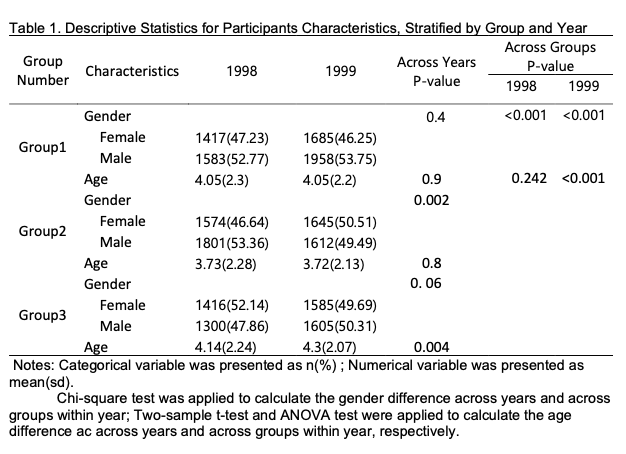

Gender distribution difference among groups in two years was found in group 1 (p-value=0.002) and mean age difference among groups in two years was found in group 3 (p-value=0.004). Gender and age unbalance were both identified when testing difference across groups in 1998 and 1999.


## Modeling strategy

### Whether Add Quadratic Terms?

In [107]:
##using data for 1998 to test
#use group2 and group3 two test whether the attendance rate change with time
fit0=geeglm(prs~num+sex+std,id =pupid,data = final_1998[!final_1998$group==1,], corstr = 'unstructured',family=binomial)
summary(fit0)$coefficients
fit0_1=geeglm(prs~I(num^2)+num+sex+std,id =pupid,data = final_1998[!final_1998$group==1,], corstr = 'unstructured',family=binomial)
summary(fit0_1)$coefficients

,Estimate,Std.err,Wald,Pr(>|W|)
(Intercept),0.9333,0.1064,76.8742,0.00e+00
num,-0.1274,0.0170,56.2480,6.38e-14
sex,-0.0225,0.0783,0.0824,7.74e-01
std,0.3120,0.0198,247.7740,0.00e+00


,Estimate,Std.err,Wald,Pr(>|W|)
(Intercept),1.6700,0.1956,72.8715,0.00e+00
I(num^2),0.0451,0.0092,24.0265,9.50e-07
num,-0.5331,0.0865,37.9620,7.21e-10
sex,-0.0233,0.0796,0.0854,7.70e-01
std,0.3258,0.0207,246.8501,0.00e+00


Comparing two models, I found that adding quadratic time term would not decrease the standard error of time term, so I decided to drop it for further analysis

### Whether Add Interaction Terms?

In [109]:
#add trt term to figure out whether the treatment effect the curve
fit1=geeglm(prs~trt*num+trt*sex+trt*std,id =pupid,data = final_1998, corstr = 'unstructured',family=binomial)
summary(fit1)$coefficients

,Estimate,Std.err,Wald,Pr(>|W|)
(Intercept),0.8914,0.1064,70.1542,0.00e+00
trt,-0.2680,0.2215,1.4633,2.26e-01
num,-0.1199,0.0170,49.6350,1.85e-12
sex,-0.0236,0.0785,0.0908,7.63e-01
std,0.3160,0.0199,253.0757,0.00e+00
trt:num,0.0729,0.0380,3.6792,5.51e-02
trt:sex,-0.0373,0.1491,0.0625,8.03e-01
trt:std,0.1093,0.0407,7.1993,7.29e-03


In [111]:
#fit 1999 data
##Create a gee with unstructed working correlation to check the correlation between measurement at different time points
fit2=geeglm(prs~pre_treat+trt*num+trt*sex+trt*std,id =pupid,data = final_1999, corstr = 'unstructured',family=binomial)
summary(fit2)$coefficients

,Estimate,Std.err,Wald,Pr(>|W|)
(Intercept),0.8721,0.1451,36.137,1.84e-09
pre_treat,-0.1140,0.0711,2.571,1.09e-01
trt,0.7816,0.1833,18.189,2.00e-05
num,-0.0811,0.0197,16.927,3.88e-05
sex,0.1096,0.0976,1.261,2.61e-01
std,0.1796,0.0240,56.242,6.41e-14
trt:num,-0.0217,0.0241,0.808,3.69e-01
trt:sex,-0.3761,0.1209,9.684,1.86e-03
trt:std,-0.0301,0.0292,1.065,3.02e-01


Interaction terms between visit, age, and treatment are significant.  
Working correlation in both models shows measurement in one time point  not largely associated with measurement in other time points.

## Results

### Analysis for Data in 1998

In [152]:
# Generate the result
fit5=geeglm(prs~trt*num+trt*sex+std,id =pupid,data = final_1998, corstr = 'unstructured',family=binomial)

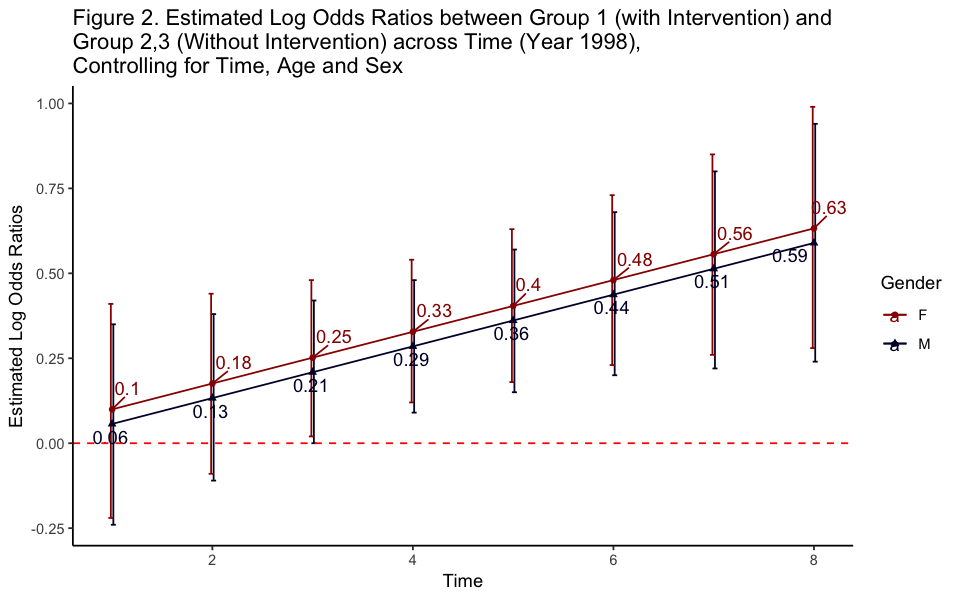

In [163]:
# Prepare the dataset for plotting
temp.result<-matrix(NA,16,8)
for (i in 8:1) {
  for (j in 0:1) {
    lambda1<-c(0,1,0,0,0,i,j)
    m<-as.matrix(esticon(fit5,lambda1))
    temp.result<-rbind(m,temp.result)
  }
}
result<-as.data.frame(temp.result[c(1:16),c(1,7:8,4)])
result[,c(2:3)]<-round(result[,c(2:3)],2)
result$Gender<-rep(c("M","F"),8)
result$Time<-rep(1:8,each=2)
results<-unite(result[1:16,], "95%CI", c(lwr, upr), sep=",")
#Plot the result
options(repr.plot.width=8, repr.plot.height=5)
result%>%ggplot(aes(x=Time, y=estimate, group=Gender,color=Gender, shape=Gender)) +
  geom_errorbar(aes(ymin=lwr, ymax=upr), width=.1, position=position_dodge(0.05)) +
  geom_line()+
  geom_point()+
  geom_text_repel(aes(label=round(estimate,2)),hjust = -0.1,vjust= -1)+
  labs(y="Estimated Log Odds Ratios",title = "Figure 2. Estimated Log Odds Ratios between Group 1 (with Intervention) and \nGroup 2,3 (Without Intervention) across Time (Year 1998), \nControlling for Time, Age and Sex")+ 
  theme_classic() + 
  scale_color_manual(values=c('#990000','#000033'))+ 
  geom_hline(yintercept=0, linetype="dashed", color = "red")

Note: Error bar represents 95% confidence interval. The estimated log odds ratio is significant if the horizontal line y=0 doesn’t across the confidence interval.  

During year 1998, the log odds ratios of attendance increased with time (become significant since the 3rd Visit) and the log odds ratios of attendance in female is higher than which in male (Figure 2). The difference of log odds ratios between two sex groups in a same visit is not significant. The log odds ratio between female in group 1 and female in group 2/3 is 0.1(95% CI -0.22, 0.41) at the first visit in 1998 while which is 0.63 (95% CI 0.28, 0.99), at the last visit in 1998, indicating the positive effect of intervention and its variation by length of intervention.

### Analysis for Data in 1999

In [156]:
#fit 1999 data
##Create a gee with unstructed working correlation to check the correlation between measurement at different time points
fit6=geeglm(prs~trt*num+pre_treat+trt*sex+std,id =pupid,data = final_1999, corstr = 'unstructured',family=binomial)

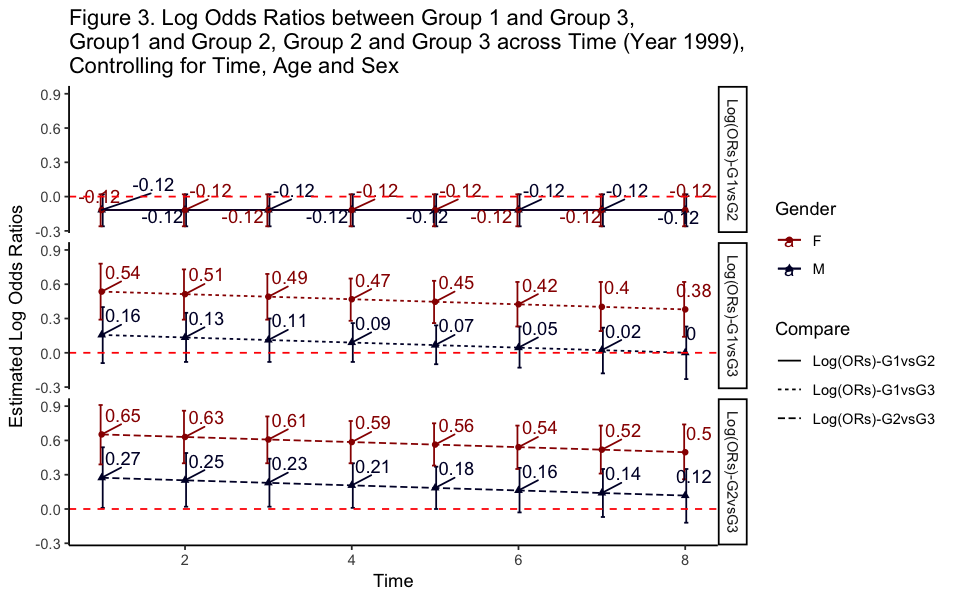

In [165]:
#Prepare the dataset for the plot
#Comparison between group 2 and group 3
temp.result<-matrix(NA,16,8)
for (i in 8:1) {
  for (j in 0:1) {
    lambda2<-c(0,1,0,0,0,0,i,j)
    m<-as.matrix(esticon(fit6,lambda2))
    temp.result<-rbind(m,temp.result)
  }
}
result_2<-as.data.frame(temp.result[c(1:16),c(1,7:8,4)])
result_2[,c(2:3)]<-round(result_2[,c(2:3)],2)
result_2$Gender<-rep(c("M","F"),8)
result_2$Time<-rep(1:8,each=2)
result_2$Compare<-rep(c("Log(ORs)-G2vsG3"),16)

#Comparison between group 1 and group 3
temp.result<-matrix(NA,16,8)
for (i in 8:1) {
  for (j in 0:1) {
    lambda1<-c(0,1,0,1,0,0,i,j)
    m<-as.matrix(esticon(fit6,lambda1))
    temp.result<-rbind(m,temp.result)
  }
}
result_1<-as.data.frame(temp.result[c(1:16),c(1,7:8,4)])
result_1[,c(2:3)]<-round(result_1[,c(2:3)],2)
result_1$Gender<-rep(c("M","F"),8)
result_1$Time<-rep(1:8,each=2)
result_1$Compare<-rep(c("Log(ORs)-G1vsG3"),16)

#Comparison between group 1 and group 2
temp.result<-matrix(NA,16,8)
for (i in 8:1) {
  for (j in 0:1) {
    lambda3<-c(0,0,0,1,0,0,0,0)
    m<-as.matrix(esticon(fit6,lambda3))
    temp.result<-rbind(m,temp.result)
  }
}
result_3<-as.data.frame(temp.result[c(1:16),c(1,7:8,4)])
result_3[,c(2:3)]<-round(result_3[,c(2:3)],2)
result_3$Gender<-rep(c("M","F"),8)
result_3$Time<-rep(1:8,each=2)
result_3$Compare<-rep(c("Log(ORs)-G1vsG2"),16)

results<-rbind(result_1,result_2,result_3)

#Plot the result
options(repr.plot.width=8, repr.plot.height=5)
results%>%ggplot(aes(x=Time, y=estimate,color=Gender,shape=Gender)) +
  geom_errorbar(aes(ymin=lwr, ymax=upr), width=.1, position=position_dodge(0.05)) +
  geom_line(aes(linetype=Compare))+
  geom_point()+
  geom_text_repel(aes(label=round(estimate,2)),hjust = -0.1,vjust= -1)+
  facet_grid(Compare~.)+
  labs(y="Estimated Log Odds Ratios",title= "Figure 3. Log Odds Ratios between Group 1 and Group 3, \nGroup1 and Group 2, Group 2 and Group 3 across Time (Year 1999),\nControlling for Time, Age and Sex")+ 
  theme_classic() + 
  geom_hline(yintercept=0, linetype="dashed", color = "red") + 
  scale_color_manual(values=c('#990000','#000033'))


Note: Error bar represents 95% confidence interval. The estimated log odds ratio is significant if the horizontal line y=0 doesn’t across the confidence interval.

During year 1999, the log odds ratios of attendance decreased with time and the log odds ratios of attendance in female is higher than which in male in comparison between group 1 and group3, as well as in comparison between group 2 and group 3 (Figure 3), for instance, among comparison between group 1 and group 3, the log OR of attendance in female is 0.54 (95% CI 0.29, 0.78), while the value in male is nearly one third of which in female, 0.16 (95% CI -0.09, 0.4), indicating the effect of intervention varied significantly between different sex groups. The log odds ratio between group 1 and group 2 is -0.12 (95% CI -0.26, 0.02), indicating insignificant effect or intervention in previous year on improving attendance. The log odds ratio between female in group 1 and female in group 3 is 0.54 (95% CI 0.29, 0.78) at the first visit in 1999 while which reduce to 0.38 at the last visit in 1999 (95% CI 0.14,0.62), indicating the positive effect of intervention and its variation by length of intervention.
